In [1]:
import numpy as np
import pandas as pd
import os

class ModelData:
    def __init__(self):
        self.name = None
        self.seed = None
        self.run = None
        self.gem = None
        self.gem_id = None
        self.pos = None
        self.people = None
        self.phases = None
        self.status = None
        self.timestep = None

        self.exposed = None
        self.new_exposed = None
        self.infected = None
        self.new_infected = None
        self.recovered = None
        self.hospital = None

# Load data
def load_data(seed, run, intervention):
    path = os.getcwd() + '/Data/Model_V1/Data/'

    data = ModelData()
    data.name = intervention
    data.seed = seed
    data.run = run
    
    data.gem = pd.read_pickle(path + 'Gemeenten.pkl')
    data.gem_id = pd.read_pickle(path +'GemeentenID.pkl')
    data.pos = np.load(path + 'Positions.npy')

    try:
        path = os.getcwd() + '/Data/Model_V1/Data/High/Seed_' + str(seed) + '/'

        data.people = pd.read_pickle(path + 'PeopleDF.pkl')

        data.phases = pd.read_pickle(path + 'Runs_' + intervention + '/Phases_' + str(run) + '.pkl')
        data.status = np.load(path + 'Runs_' + intervention + '/Status_' + str(run) + '.npz')
        data.timestep = np.loadtxt(path + 'Runs_' + intervention + '/Timestep_' + str(run))
        print("Loaded data ({}, {}, {})".format(intervention, seed, run))
    except:
        print("Error loading data ({}, {}, {})".format(intervention, seed, run))
        return

    return data


seeds = [1, 2]
ei_l = [3, 3.5, 4, 4.5, 5, 5.5, 6]
ir_l = [3, 4, 5, 6, 7, 8, 9, 10]
to_import = list(set(ei_l).union(set(ir_l)))
interventions = ['ref']

data_points = []
for seed in seeds:
    for run in to_import:
        for intervention in interventions:
            data_points.append(load_data(seed, run, intervention))

data_points = list(filter(None, data_points))
print('Succesfully loaded ' + str(len(data_points)) + ' data points')

C:\Users\Larsk\AppData\Local\Temp\ipykernel_16328\545763093.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Loaded data (ref, 1, 3.5)
Loaded data (ref, 1, 3)
Loaded data (ref, 1, 5)
Loaded data (ref, 1, 4)
Loaded data (ref, 1, 4.5)
Loaded data (ref, 1, 5.5)
Loaded data (ref, 1, 6)
Error loading data (ref, 1, 7)
Error loading data (ref, 1, 8)
Error loading data (ref, 1, 9)
Error loading data (ref, 1, 10)
Error loading data (ref, 2, 3.5)
Loaded data (ref, 2, 3)
Loaded data (ref, 2, 5)
Loaded data (ref, 2, 4)
Error loading data (ref, 2, 4.5)
Error loading data (ref, 2, 5.5)
Loaded data (ref, 2, 6)
Loaded data (ref, 2, 7)
Loaded data (ref, 2, 8)
Loaded data (ref, 2, 9)
Loaded data (ref, 2, 10)
Succesfully loaded 15 data points


In [2]:
import math

# map containing hospitalisation values per demographic group
p_hos_map = {
    'a) Pre-school children':       0,
    'b) Primary school children':   0,
    'c) Secondary school children': 0.0018,
    'd) Students':                  0.0006,
    'e) Non-studying adolescents':  0.0006,
    'f) Middle-age working':        0.0081,
    'g) Middle-age unemployed':     0.0081,
    'h) Higher-age working':        0.0276,
    'i) Higher-age unemployed':     0.0276,
    'j) Elderly':                   0.0494,
    'k) Eldest':                    0.0641
}

people_per_agent = 100

# Weibull distrubution parameters
mean = 14
scale = 10
shape = mean / (math.gamma(1 + 1 / scale))

# Compute model data per timestep
for data in data_points:
    timesteps = data.status['indptr'].shape[0] -1
    raw_data = data.status['data']
    indptr = data.status['indptr']
    indices = data.status['indices']

    data.hospital = np.zeros(timesteps)
    data.exposed = np.zeros(timesteps)
    data.new_exposed = np.zeros(timesteps)
    data.infected = np.zeros(timesteps)
    data.new_infected = np.zeros(timesteps)
    data.recovered = np.zeros(timesteps)

    prev_exposed = set()
    prev_infected = set()
    for t in range(0, timesteps):
        timestamp_row = raw_data[indptr[t] : indptr[t + 1]]
        affected_agents = indices[indptr[t] : indptr[t + 1]]

        exposed_mask = timestamp_row == 1
        infected_mask = timestamp_row == 2
        exposed_row = affected_agents[exposed_mask]
        infected_row = affected_agents[infected_mask]

        # get new exposed/infected cases a.k.a people that were not previously exposed/infected
        new_exposed = set(exposed_row).difference(prev_exposed)
        new_infected = set(infected_row).difference(prev_infected)
        prev_exposed = exposed_row
        prev_infected = infected_row

        #print('exp: ' + str(len(new_exposed)) + ' inf: ' +  str(len(new_infected)))

        # Compute which agents will be hospitalised (based on p_hos), and after how long (based on weibull distribution mean 14, scale 10)
        # The chance is rolled individually for every person represented by an agent (so 100 rolls per infected agent)
        count_infected_ppl = len(new_infected) * people_per_agent
        p_hos = [p_hos_map[data.people['Group'][agent]] for agent in new_infected]
        p_hos_people = np.repeat(p_hos, people_per_agent)
        mask_hos = np.random.rand(count_infected_ppl) < p_hos_people
        time_lag = 24 * np.random.weibull(5, size=count_infected_ppl) * mean
        hos_time = time_lag[mask_hos].astype(int)
        
        # Store the hospitalisation on correct timestep
        for ht in hos_time:
            time = t + ht
            if time < timesteps:
                data.hospital[time] += 1
        
        # assign data to object
        data.exposed[t] = len(exposed_row) * people_per_agent
        data.new_exposed[t] = len(new_exposed) * people_per_agent
        data.infected[t] = len(infected_row) * people_per_agent
        data.new_infected[t] = len(new_infected) * people_per_agent
        data.recovered[t] = np.count_nonzero(timestamp_row == 3) * people_per_agent

# Check some general info
# print(data_points[0].infected.size)
# print(np.argmin(data_points[0].infected))
        

In [7]:
import copy

# Compute the average over all the runs for the raw data
agg_data_points = []
for raw_data in data_points:
    agg_data = copy.copy(raw_data)
    agg_data.new_exposed = np.sum(agg_data.new_exposed.reshape(-1,24),axis=1)
    agg_data.new_infected = np.sum(agg_data.new_infected.reshape(-1,24),axis=1)
    agg_data.recovered = np.sum(agg_data.recovered.reshape(-1,24),axis=1)
    agg_data.hospital = np.sum(agg_data.hospital.reshape(-1,24),axis=1)
    agg_data_points.append(agg_data)

#avg_ref_data = data_points[0]

In [8]:
import pandas as pd
import numpy as np

hosp_data = pd.read_csv('Data/COVID-19_ziekenhuisopnames_tm_03102021.csv', delimiter=';', encoding='latin-1')
daily_addmisions = hosp_data['Hospital_admission'].groupby(hosp_data['Date_of_statistics']).sum().to_numpy()

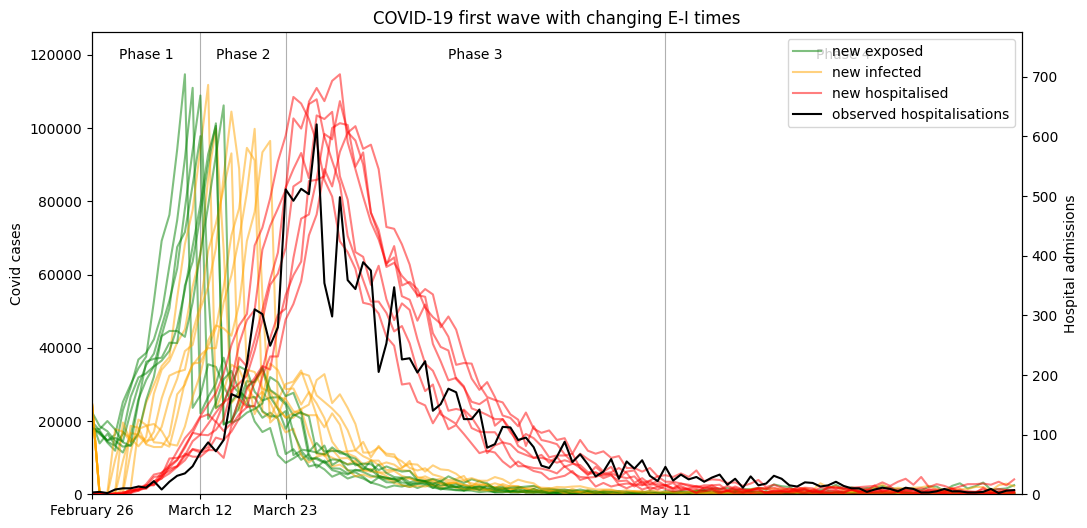

In [20]:
import matplotlib.pyplot as plt

# Recreates figure 2(a) of the paper
agg_ref_data = [data for data in agg_data_points if data.seed == 1]
agg_ref_data_point = agg_ref_data[0]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

plt.title('COVID-19 first wave with changing E-I times')
plt.xlabel('time (h)')

ax1.set_ylabel('Covid cases')
ax2.set_ylabel('Hospital admissions')

#Get starts of phases
phase2 = np.argmax(agg_ref_data_point.phases[0]==2)
phase3 = np.argmax(agg_ref_data_point.phases[0]==3)
phase4 = np.argmax(agg_ref_data_point.phases[0]==4) # might be 0 if model ran for too little days, dont include in 'phases' list in that case
phase1 = phase2 - 14 * 24 # feb 27th is 14 days before march 12th

phases = [phase1, phase2, phase3, phase4]

x_max = timesteps
plt.xlim(phase1, x_max)
y1_max = np.max([point for data in agg_ref_data for point in data.new_exposed])
y2_max = np.max([point for data in agg_ref_data for point in data.hospital])
ax1.set_ylim([0, y1_max * 1.1])
ax2.set_ylim([0, y2_max * 1.1])

lines = []
time_range_daily = np.arange(0, x_max, 24)
for run in agg_ref_data:
    ln1 = ax1.plot(time_range_daily, run.new_exposed, label='new exposed', color='green', alpha=0.5)
    ln2 = ax1.plot(time_range_daily, run.new_infected, label='new infected', color='orange', alpha=0.5)
    ln3 = ax2.plot(time_range_daily, run.hospital, label='new hospitalised', color='red', alpha=0.5)
    lines = ln1 + ln2 + ln3
ln4 = ax2.plot(time_range_daily, daily_addmisions[:120], label='observed hospitalisations', color='black')
lines = lines + ln4

# Print phase labels on top of graph
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phase_label_pos = np.array([phase2 /2, (phase3+phase2) / 2, (phase4+phase3) / 2, (x_max+phase4) / 2]) / x_max
for label, pos in zip(phase_labels, phase_label_pos):
    ax1.text(pos, 0.95, label, transform=ax1.transAxes,
         ha='center', va='center', fontsize=10)

# Compute phase date
march12 = pd.to_datetime('2022-03-12')
date_p1 = march12 + pd.DateOffset(hours= -int(phase2-phase1))
date_p3 = march12 + pd.DateOffset(hours=  int(phase3-phase2))
date_p4 = march12 + pd.DateOffset(hours=  int(phase4-phase2))

# Print specific date labels on x-axis
ax1.grid(axis='x')
ax1.set_xticks(phases, map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3, date_p4]))
ax1.legend(lines, [l.get_label() for l in lines])
plt.show()

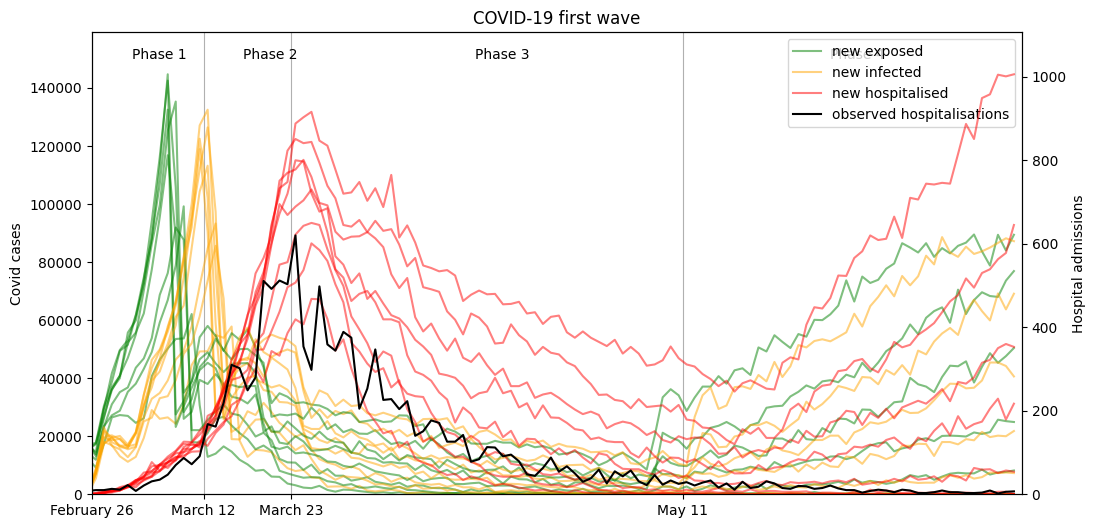

In [11]:
import matplotlib.pyplot as plt

# Recreates figure 2(a) of the paper
agg_ref_data = [data for data in agg_data_points if data.seed == 2]
agg_ref_data_point = agg_ref_data[0]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

plt.title('COVID-19 first wave with changing I-R times')
plt.xlabel('time (h)')

ax1.set_ylabel('Covid cases')
ax2.set_ylabel('Hospital admissions')

#Get starts of phases
phase2 = np.argmax(agg_ref_data_point.phases[0]==2)
phase3 = np.argmax(agg_ref_data_point.phases[0]==3)
phase4 = np.argmax(agg_ref_data_point.phases[0]==4) # might be 0 if model ran for too little days, dont include in 'phases' list in that case
phase1 = phase2 - 14 * 24 # feb 27th is 14 days before march 12th

phases = [phase1, phase2, phase3, phase4]

x_max = timesteps
plt.xlim(phase1, x_max)
y1_max = np.max([point for data in agg_ref_data for point in data.new_exposed])
y2_max = np.max([point for data in agg_ref_data for point in data.hospital])
ax1.set_ylim([0, y1_max * 1.1])
ax2.set_ylim([0, y2_max * 1.1])

lines = []
time_range_daily = np.arange(0, x_max, 24)
for run in agg_ref_data:
    ln1 = ax1.plot(time_range_daily, run.new_exposed, label='new exposed', color='green', alpha=0.5)
    ln2 = ax1.plot(time_range_daily, run.new_infected, label='new infected', color='orange', alpha=0.5)
    ln3 = ax2.plot(time_range_daily, run.hospital, label='new hospitalised', color='red', alpha=0.5)
    lines = ln1 + ln2 + ln3
ln4 = ax2.plot(time_range_daily, daily_addmisions[:120], label='observed hospitalisations', color='black')
lines = lines + ln4

# Print phase labels on top of graph
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phase_label_pos = np.array([phase2 /2, (phase3+phase2) / 2, (phase4+phase3) / 2, (x_max+phase4) / 2]) / x_max
for label, pos in zip(phase_labels, phase_label_pos):
    ax1.text(pos, 0.95, label, transform=ax1.transAxes,
         ha='center', va='center', fontsize=10)

# Compute phase date
march12 = pd.to_datetime('2022-03-12')
date_p1 = march12 + pd.DateOffset(hours= -int(phase2-phase1))
date_p3 = march12 + pd.DateOffset(hours=  int(phase3-phase2))
date_p4 = march12 + pd.DateOffset(hours=  int(phase4-phase2))

# Print specific date labels on x-axis
ax1.grid(axis='x')
ax1.set_xticks(phases, map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3, date_p4]))
ax1.legend(lines, [l.get_label() for l in lines])
plt.show()

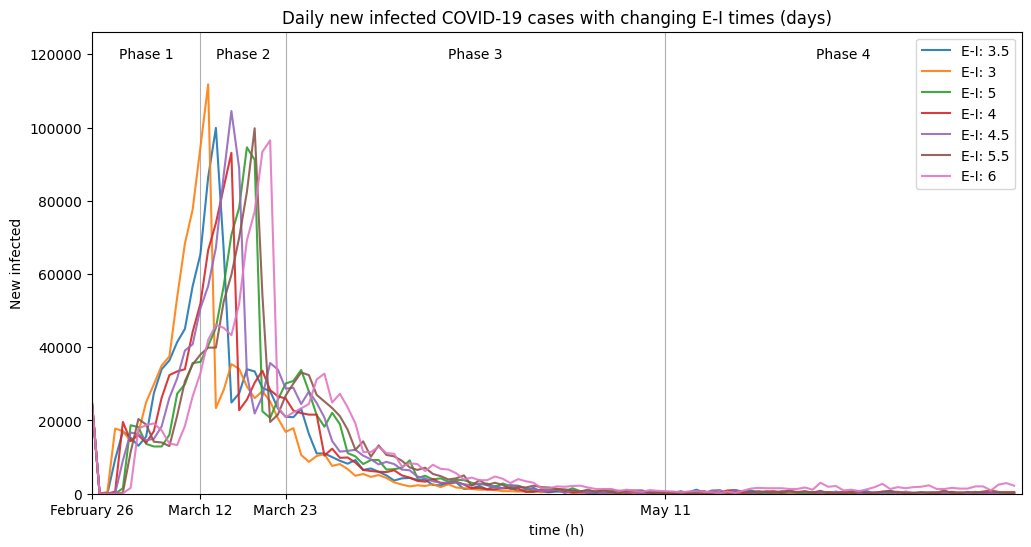

In [19]:
import matplotlib.pyplot as plt

# Recreates figure 2(a) of the paper
agg_ref_data = [data for data in agg_data_points if data.seed == 1]
agg_ref_data_point = agg_ref_data[0]

fig, ax1 = plt.subplots(figsize=(12, 6))

plt.title('Daily new infected COVID-19 cases with changing E-I times')
plt.xlabel('time (h)')

ax1.set_ylabel('New infected')

#Get starts of phases
phase2 = np.argmax(agg_ref_data_point.phases[0]==2)
phase3 = np.argmax(agg_ref_data_point.phases[0]==3)
phase4 = np.argmax(agg_ref_data_point.phases[0]==4) # might be 0 if model ran for too little days, dont include in 'phases' list in that case
phase1 = phase2 - 14 * 24 # feb 27th is 14 days before march 12th

phases = [phase1, phase2, phase3, phase4]

x_max = timesteps
plt.xlim(phase1, x_max)
y1_max = np.max([point for data in agg_ref_data for point in data.new_exposed])
ax1.set_ylim([0, y1_max * 1.1])

lines = []
time_range_daily = np.arange(0, x_max, 24)
for run in agg_ref_data:
    ln2 = ax1.plot(time_range_daily, run.new_infected, label='E-I: ' + str(run.run), alpha=0.9)
    lines = lines + ln2

# Print phase labels on top of graph
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phase_label_pos = np.array([phase2 /2, (phase3+phase2) / 2, (phase4+phase3) / 2, (x_max+phase4) / 2]) / x_max
for label, pos in zip(phase_labels, phase_label_pos):
    ax1.text(pos, 0.95, label, transform=ax1.transAxes,
         ha='center', va='center', fontsize=10)

# Compute phase date
march12 = pd.to_datetime('2022-03-12')
date_p1 = march12 + pd.DateOffset(hours= -int(phase2-phase1))
date_p3 = march12 + pd.DateOffset(hours=  int(phase3-phase2))
date_p4 = march12 + pd.DateOffset(hours=  int(phase4-phase2))

# Print specific date labels on x-axis
ax1.grid(axis='x')
ax1.set_xticks(phases, map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3, date_p4]))
ax1.legend(lines, [l.get_label() for l in lines])
plt.show()

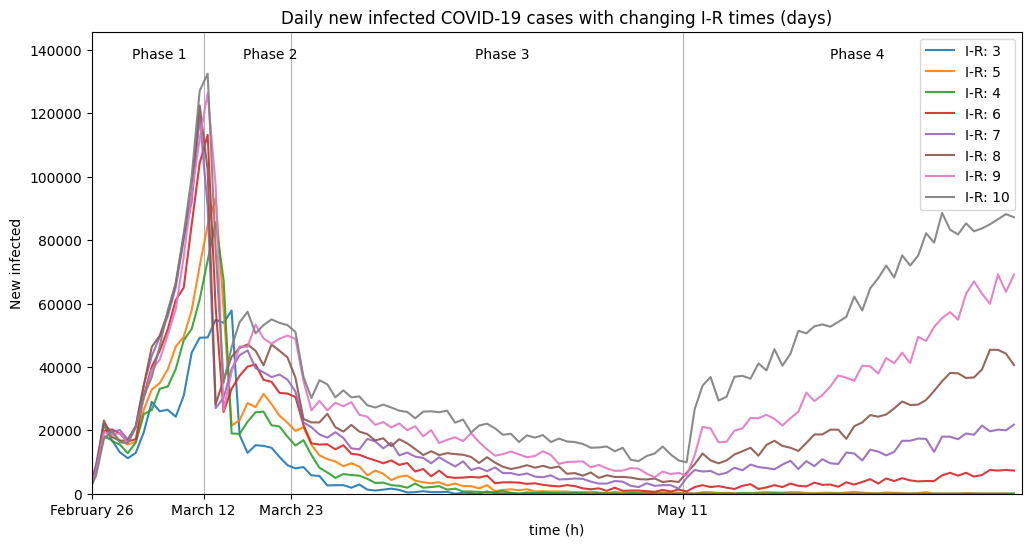

In [18]:
import matplotlib.pyplot as plt

# Recreates figure 2(a) of the paper
agg_ref_data = [data for data in agg_data_points if data.seed == 2]
agg_ref_data_point = agg_ref_data[0]

fig, ax1 = plt.subplots(figsize=(12, 6))

plt.title('Daily new infected COVID-19 cases with changing I-R times (days)')
plt.xlabel('time (h)')

ax1.set_ylabel('New infected')

#Get starts of phases
phase2 = np.argmax(agg_ref_data_point.phases[0]==2)
phase3 = np.argmax(agg_ref_data_point.phases[0]==3)
phase4 = np.argmax(agg_ref_data_point.phases[0]==4) # might be 0 if model ran for too little days, dont include in 'phases' list in that case
phase1 = phase2 - 14 * 24 # feb 27th is 14 days before march 12th

phases = [phase1, phase2, phase3, phase4]

x_max = timesteps
plt.xlim(phase1, x_max)
y1_max = np.max([point for data in agg_ref_data for point in data.new_infected])
ax1.set_ylim([0, y1_max * 1.1])

lines = []
time_range_daily = np.arange(0, x_max, 24)
for run in agg_ref_data:
    ln2 = ax1.plot(time_range_daily, run.new_infected, label='I-R: ' + str(run.run), alpha=0.9)
    lines = lines + ln2

# Print phase labels on top of graph
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phase_label_pos = np.array([phase2 /2, (phase3+phase2) / 2, (phase4+phase3) / 2, (x_max+phase4) / 2]) / x_max
for label, pos in zip(phase_labels, phase_label_pos):
    ax1.text(pos, 0.95, label, transform=ax1.transAxes,
         ha='center', va='center', fontsize=10)

# Compute phase date
march12 = pd.to_datetime('2022-03-12')
date_p1 = march12 + pd.DateOffset(hours= -int(phase2-phase1))
date_p3 = march12 + pd.DateOffset(hours=  int(phase3-phase2))
date_p4 = march12 + pd.DateOffset(hours=  int(phase4-phase2))

# Print specific date labels on x-axis
ax1.grid(axis='x')
ax1.set_xticks(phases, map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3, date_p4]))
ax1.legend(lines, [l.get_label() for l in lines])
plt.show()